In [1]:
import numpy as np
import types
from tqdm import tqdm

# 一、numpy实现CNN

In [2]:
# 激活函数
class Func:
    def __init__(self,f:types.FunctionType,f_derivate:types.FunctionType,jacobin=False):
        self.f=f
        self.f_derivate=f_derivate
        self.jacobin=jacobin # True表明f导数将使用雅克比矩阵进行表示

    # 激活函数正向传播
    def __call__(self,z):
        return self.f(z)

    # 激活函数反向传播（求导）
    def derivate(self,z):
        return self.f_derivate(z)        

In [3]:
from abc import abstractmethod

# 网络层，正向传播相应方法为__call__，反向传播相应方法为backward
class Layer:
    @abstractmethod
    def __call__(self,x:np.ndarray)->np.ndarray:
        pass

    @abstractmethod
    def backward(self,d:np.ndarray)->np.ndarray:
        pass

In [4]:
# 定义损失函数
class LossFunc:
    def __init__(self,f:types.FunctionType,f_derivate:types.FunctionType):
        self.f=f
        self.f_derivate=f_derivate

    def __call__(self,label,predict):
        return self.f(label,predict)

    def derivate(self,label,predict):
        return self.f_derivate(label,predict)

# 平方和（sum squared error）
def f_sum_of_squared_error(label,predict):
    return (label-predict)**2

def f_sum_of_squared_error_derivate(label,predict):
    return 2*(predict-label)

# 平方和误差
sse=LossFunc(f_sum_of_squared_error,f_sum_of_squared_error_derivate)      

# 交叉熵
def f_sum_of_cross_entropy_error(label,predict):
    delta=1e-20
    return -np.sum(label*np.log(predict+delta))

def f_sum_of_cee_derivate(label,predict):
    return -label/predict

cee=LossFunc(f_sum_of_cross_entropy_error,f_sum_of_cee_derivate)    

In [5]:
# reshape层，主要用于卷积层和全连接层的衔接
# from_shape可以为None，输入第一个矩阵后自动获取shape
# to_shape为(1,-1)，因为全连接层的输入就是一个一维张量，用二维表示只是方便用array.dot
class ReshapeLayer(Layer):
    def __init__(self,from_shape,to_shape):
        self.from_shape=from_shape
        self.to_shape=to_shape

    def __call__(self,x:np.ndarray)->np.ndarray:
        if self.from_shape is None:
            self.from_shape=x.shape
        return x.reshape(self.to_shape)

    def backward(self,d:np.ndarray)->np.ndarray:
        # print("backward:reshapeLayer")
        return d.reshape(self.from_shape)            

In [6]:
# 激活函数层
class ActivateLayer(Layer):
    def __init__(self,activate_fn:Func):
        self.f=activate_fn
        self.z:np.ndarray=None

    def __call__(self,x:np.ndarray)->np.ndarray:
        self.z=x
        return self.f(x)

    def backward(self,dc_da:np.ndarray)->np.ndarray:
        # print("backward:ActivateLayer")
        # 作为最后一个激活函数，它接收的dc_da为(-1/n)*(label/pred)*(-lr)
        da_dz=self.f.derivate(self.z)
        if self.f.jacobin:
            # 如果求导结果只能表示成雅克比矩阵，得用矩阵乘法
            dc_dz=dc_da.dot(da_dz.T)
        else:
            # 如果求导结果为对角矩阵，可以采用逐值相乘来简化运算
            dc_dz=dc_da*da_dz
        return dc_dz                

In [7]:
# 定义relu激活函数
def f_relu(z):
    return np.maximum(z,0)

def f_relu_derivate(z):
    return np.heaviside(z,0.5)

relu=Func(f_relu,f_relu_derivate)

# 定义sigmoid激活函数
def f_sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def f_sigmoid_derivate(z):
    y=f_sigmoid(z)
    return y*(1-y)

sigmoid=Func(f_sigmoid,f_sigmoid_derivate)

# 定义softmax激活函数
# 之所以要乘一个exp(-max(z))，是为了防止计算结果超出浮点数的范围，比如exp(500)
def f_softmax(z):
    # 得到的z是个1*n的数组，因此要取z=z[0]
    # z=z[0]
    exps=np.exp(z-np.max(z))
    exp_sum=np.sum(exps)
    b=exps/exp_sum
    return b[0]

def f_softmax_derivate(z):
    y=f_softmax(z).reshape((-1,))
    # 相当于Iy-y·y^T
    return np.diag(y)-y.reshape((-1,1)).dot(y.reshape(1,-1))

softmax=Func(f_softmax,f_softmax_derivate,True)

In [8]:
# 全连接层
class FullConnectedLayer(Layer):
    def __init__(self,input_size,output_size):
        self.i_size=input_size
        self.o_size=output_size
        if self.i_size is not None:
            self.__init(self.i_size)

    # 初始化权重，并为输入矩阵x留一个坑位
    def __init(self,input_size):
        self.i_size=input_size
        self.w=np.random.normal(loc=0.0,scale=1.0,size=(self.i_size,self.o_size))
        self.b=np.random.normal(loc=0.0,scale=1.0,size=(1,self.o_size))
        self.x: np.ndarray=None # input

    def __call__(self,x:np.ndarray)->np.ndarray:    
        x=x.reshape(1,-1)
        if self.i_size is None:
            # x的第一维是1，第二维就是输入的尺寸
            self.__init(x.shape[1])
        self.x=x
        self.z=x.dot(self.w)+self.b
        return self.z

    # 反向传播
    def backward(self,dc_dz:np.ndarray)->np.ndarray:
        '''
            输入是单个样本的误差，输出也是单个样本的误差，因此这一层反向传播时，需要把各个样本的误差重新组合起来，形成一个完整的误差矩阵，才可以继续反向传播到其它层
        '''
        # print("backward:FullConnectedLayer")
        dc_dx=dc_dz.dot(self.w.T)    
        self.w+=self.x.T.dot(dc_dz.reshape((1,-1)))
        self.b+=dc_dz
        return dc_dx

In [9]:
# 平均池化层
class MeanPoolingLayer(Layer):
    def __init__(self,kernel_size:int,stride:int):
        self.ks=kernel_size
        self.kernel_shape=(kernel_size,kernel_size)
        self.channels:int=None
        self.stride=stride
        self.input_shape:tuple=None # row_cnt,col_cnt,channels
        self.target_shape:tuple=None # 目标的shape

    # 第3维为通道数
    def __call__(self,mat:np.ndarray):
        self.input_shape=mat.shape
        self.channels=mat.shape[2] 
        row,col=mat.shape[0],mat.shape[1]
        (kr,kc),s=self.kernel_shape,self.stride
        self.target_shape=((row-kr)//s+1,(col-kc)//s+1,self.channels) 
        target=np.zeros(self.target_shape)
        for i in range(self.target_shape[0]):
            for j in range(self.target_shape[1]):
                r,c=i*s,j*s
                target[i,j]=np.average(mat[r:r+kr,c:c+kc],axis=(0,1))
        return target

    def backward(self,d_out:np.ndarray)->np.ndarray:
        # print("backward:MeanPoolingLayer")
        d_input=np.zeros(self.input_shape)
        n=self.kernel_shape[0]*self.kernel_shape[1]
        d_mat=d_out/n
        (kr,kc),s=self.kernel_shape,self.stride
        for i in range(self.target_shape[0]):
            for j in range(self.target_shape[1]):
                r,c=i*s,j*s
                d_input[r:r+kr,c:c+kc]+=d_mat[i,j]
                # 如果需要传入学习率，那应该用下面这行
                # d_input[r:r+kr,c:c+kc]+=lr*d_mat[i,j]
        return d_input        

In [10]:
from typing import Optional,Iterable

# 卷积层
class ConvolutionLayer(Layer):
    # 初始化
    def __init__(self,in_channels,out_channels,kernel_size,stride):
        self.in_channels=in_channels
        self.out_channels=out_channels
        self.ks=kernel_size
        self.kernel_shape=(kernel_size,kernel_size)
        self.stride=stride
        self.x:Optional[np.ndarray]=None
        # 卷积核：row,col,channel
        # 共有out_channels个(row,col,in_channels)的kernels
        self.kernel=np.random.normal(loc=0.0,scale=1.0,size=(kernel_size,kernel_size,in_channels,out_channels,))
        # 每个卷积核共用一个bias，总共有out_channels个bias
        self.bias=np.random.normal(loc=0.0,scale=1.0,size=(out_channels,))

    def check_x_mat_shape(self,x_mat):
        '''
            要求卷积核在卷积时可以把矩阵铺满，右侧不能有多余的列，下侧不能有多余的行
            如28×28不能用（5×5，stride=2）的卷积核，因为它只能覆盖（27×27）
        '''    
        row,col=x_mat.shape[0],x_mat.shape[1]
        k,s=self.ks,self.stride
        assert (row-k) // s*s + k ==row
        assert (col-k) // s*s + k ==col

    def __call__(self,x_mat:np.ndarray)->np.ndarray:
        self.check_x_mat_shape(x_mat)
        self.x=x_mat
        # 做卷积运算
        return self.__conv(
            stride=self.stride,
            mat=x_mat,
            kernel=self.kernel,
            bias=None,
            einsum_formula="ijk,ijkl->l",
            out_ele_shape=[self.out_channels]
            )

    def backward(self,dc_dz:np.ndarray)->np.ndarray:
        # 反向卷积的目标是dc_dz补0后的矩阵（张量）
        # （padding+dilation）
        # 补0规则为：边缘padding kernel_size-1 层0；间隔处补stride-1层0
        # 只看横向，如果dc_dz有c列，那该矩阵有2kernel_size+(m-1)stride-1列
        # 反向卷积的stride固定为1
        # print("backward:ConvLayer")
        (kr,kc,in_ch,out_ch),s=self.kernel.shape,self.stride
        dc_dz_with_zeros_shape=(
            2*kr+(dc_dz.shape[0]-1)*s-1,
            2*kc+(dc_dz.shape[1]-1)*s-1,
            dc_dz.shape[2]
        )        
        # 用D表示补0后的张量
        D=np.zeros(dc_dz_with_zeros_shape)
        for i in range(dc_dz.shape[0]):
            for j in range(dc_dz.shape[1]):
                D[kr+i*s-1,kc+j*s-1]=dc_dz[i,j]

        # 求dc_da,a指该层的输入self.x
        # 此时需注意步长是1
        # kernel[i,j,k,l]在正向推导时i表示row,j表示col,k表示in_ch,l表示out_ch
        # 反向推导时i表示row,j表示col,l表示in_ch,k表示out_ch，其余计算步骤和正向推导一致
        dc_da=self.__conv(
            stride=1,
            mat=D,
            kernel=self.kernel[::-1,::-1],
            bias=None,
            einsum_formula="ijl,ijkl->k",
            out_ele_shape=[in_ch]
        )        
        # 求dc_dw，也是卷积，只不过是用D对a_input卷积
        dc_dw=self.__conv(
            stride=1,
            mat=self.x,
            kernel=dc_dz,
            bias=None,
            einsum_formula="ijk,ijl->kl",
            out_ele_shape=[in_ch,out_ch]
        )

        

        # 求dc_db
        dc_db=np.einsum("ijk->k",dc_dz)
        # 更新w和b，并返回dc_da
        self.kernel+=dc_dw
        self.bias+=dc_db

        return dc_da

    # 它的返回值就是卷积层前向传播时的返回值
    def __conv(self,
                    stride:int,
                    mat:np.ndarray,
                    kernel:np.ndarray,
                    bias:np.ndarray=None,
                    einsum_formula:str="ijk,ijkl->l",
                    out_ele_shape:Iterable[int]=None)->np.ndarray:
            # 卷积运算 sub_np_tensor*kernel_np_tensor+bias
            if bias is None:
                def f(m):
                    return np.einsum(einsum_formula,m,kernel)
            else:
                def f(m):
                    return np.einsum(einsum_formula,m,kernel)+bias  
            row,col=mat.shape[0],mat.shape[1]
            s=stride
            (kr,kc,*omit),s=kernel.shape,stride
            # 正向推导
            if out_ele_shape is None:
                assert len(kernel.shape)==3
                out_ch=kernel.shape[-1]
                out_ele_shape=(out_ch,)

            target_shape=((row-kr)//s+1,(col-kc)//s+1,*out_ele_shape)
            target = np.zeros(target_shape)
            for i in range(target_shape[0]):
                for j in range(target_shape[1]):
                    r,c=i*s,j*s
                    target[i,j]=f(mat[r:r+kr,c:c+kc])
            return target                          


In [11]:
# 神经网络
class NN:
    def __init__(self,input_shape=(1,-1),output_shape=(1,-1)):
        self.layers=list()
        self.input_shape=input_shape
        self.output_shape=output_shape

    def predict(self,test_X:np.ndarray):
        n_samples=test_X.shape[0]
        pred=[]
        for i in range(n_samples):
            pred.append(self.forward(test_X[i]))
        return pred    

    def forward(self,a:np.ndarray)->np.ndarray:
        for layer in self.layers:
            a=layer(a)  
        return a   

    # 神经网络的反向传播
    def backward(self,dc_da_last:np.ndarray)->np.ndarray:
        # print("begin NN backward")
        # dc_da_last=loss*-lr，即dc_da_last=-lr*1/n*(label/pred),形状为n_samples*n_class
        d=dc_da_last # 这样只是方便表示而已
        for layer in self.layers[::-1]:
            d=layer.backward(d)    
        return d

    def train(self,input_vec,label,loss_func:LossFunc,lr):
        n_samples=input_vec.shape[0]
        for i in tqdm(range(n_samples)):
            y=self.forward(input_vec[i])
            label_dilation=np.zeros((y.shape))
            label_dilation[label[i]]=1
            loss=loss_func.derivate(label_dilation,y)
            self.backward(loss*-lr)
            

    def set_layers(self,layers):
        self.layers=layers

    def append(self,layer):
        self.layers.append(layer)                         

In [12]:
def evaluate(pred,label):
    n_samples=len(label)
    t=0
    for i in range(n_samples):
        if np.argmax(pred[i])==label[i]:
            t+=1
    return t*1.0/n_samples        

In [13]:
import numpy as np
import struct
def load_images(file_name):
    ##   在读取或写入一个文件之前，你必须使用 Python 内置open()函数来打开它。##
    ##   file object = open(file_name [, access_mode][, buffering])          ##
    ##   file_name是包含您要访问的文件名的字符串值。                         ##
    ##   access_mode指定该文件已被打开，即读，写，追加等方式。               ##
    ##   0表示不使用缓冲，1表示在访问一个文件时进行缓冲。                    ##
    ##   这里rb表示只能以二进制读取的方式打开一个文件                        ##
    binfile = open(file_name, 'rb') 
    ##   从一个打开的文件读取数据
    buffers = binfile.read()
    ##   读取image文件前4个整型数字
    magic,num,rows,cols = struct.unpack_from('>IIII',buffers, 0)
    ##   整个images数据大小为60000*28*28
    bits = num * rows * cols
    ##   读取images数据
    images = struct.unpack_from('>' + str(bits) + 'B', buffers, struct.calcsize('>IIII'))
    ##   关闭文件
    binfile.close()
    ##   转换为[60000,784]型数组
    images = np.reshape(images, [num, rows , cols,1])
    images=images.astype(float)
    return images

def load_labels(file_name):
    ##   打开文件
    binfile = open(file_name, 'rb')
    ##   从一个打开的文件读取数据    
    buffers = binfile.read()
    ##   读取label文件前2个整形数字，label的长度为num
    magic,num = struct.unpack_from('>II', buffers, 0) 
    ##   读取labels数据
    labels = struct.unpack_from('>' + str(num) + "B", buffers, struct.calcsize('>II'))
    ##   关闭文件
    binfile.close()
    ##   转换为一维数组
    labels = np.reshape(labels, [num])
    # labels=labels.astype(float)
    return labels   

In [14]:
filename_train_images = './MNIST/train/train-images-idx3-ubyte'
filename_train_labels = './MNIST/train/train-labels-idx1-ubyte'
filename_test_images = './MNIST/test/t10k-images-idx3-ubyte'
filename_test_labels = './MNIST/test/t10k-labels-idx1-ubyte'
train_images=load_images(filename_train_images)
train_labels=load_labels(filename_train_labels)
test_images=load_images(filename_test_images)
test_labels=load_labels(filename_test_labels)
max_pixel=255
train_images=train_images/255
test_images=test_images/255

In [15]:
test_images[:10].shape

(10, 28, 28, 1)

In [16]:
train_images[:10].shape

(10, 28, 28, 1)

In [17]:
test_labels.shape

(10000,)

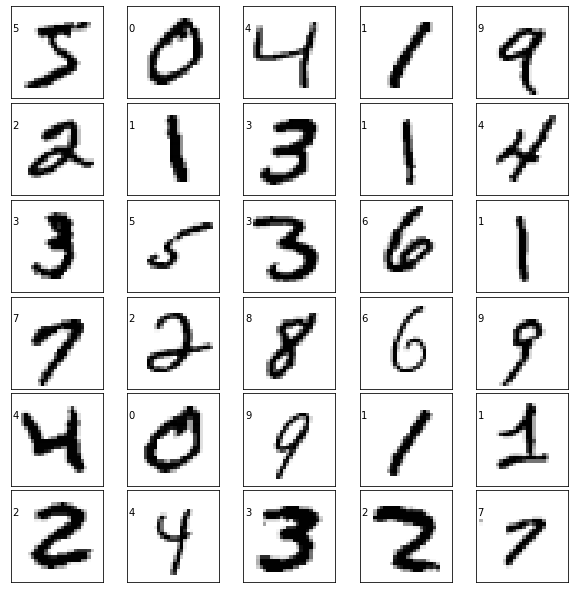

In [18]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.05,wspace=0.05)
for i in range(30):
    images = train_images[i]
    # print(images[5])
    ax=fig.add_subplot(6,5,i+1,xticks=[],yticks=[])
    ax.imshow(images,cmap=plt.cm.binary,interpolation='nearest')
    ax.text(0,7,str(train_labels[i]))
plt.show()

In [19]:
# MNIST
def train_model(train_X,train_Y,epochs,class_num,lr):
    my_nn=NN(train_X[0].shape,(1,1))
    my_nn.set_layers([
        # 神经网络的结构
        # conv1
        # ConvolutionLayer(in_channels= 1,out_channels= 6,kernel_size= 5,stride= 1),
        ConvolutionLayer(in_channels= train_X.shape[-1],out_channels= 6,kernel_size= 5,stride= 1),
        # relu1
        ActivateLayer(relu),
        # pool1
        MeanPoolingLayer(2,2),
        # relu1
        ActivateLayer(relu),
        # flat
        ReshapeLayer(None,(1,-1)),
        # fc1
        FullConnectedLayer(None,class_num),
        # softmax(SM)
        ActivateLayer(softmax),
    ])
    print(f"in_channels={train_X.shape[-1]}")
    for i in tqdm(range(epochs)):
        my_nn.train(train_X,train_Y,cee,lr)
    print(f"convolutionlayer.kernel={my_nn.layers[0].kernel}")
    return my_nn

# model=train_model(train_images[:10],train_labels[:10],epochs=100,class_num=10,lr=0.001)

In [47]:
model_2=train_model(train_images,train_labels,epochs=70,class_num=10,lr=0.001)
pred=model_2.predict(test_images)
evaluate(pred,test_labels)

100%|██████████| 70/70 [7:57:00<00:00, 408.86s/it]


convolutionlayer.kernel=[[[[-9.77852290e-01  9.08195026e-01  1.12172165e+00 -8.60554639e-01]]

  [[-1.44215340e+00 -1.38485841e-01 -3.31071332e-01 -5.18808365e-01]]

  [[-9.16182205e-01  1.16548643e+00 -1.26437533e+00 -9.80350881e-01]]]


 [[[-1.97863905e-01 -5.28324413e-01 -6.90827372e-02 -5.01702269e-01]]

  [[-1.36747119e-01  9.45892153e-01  7.13925457e-01 -1.25918243e+00]]

  [[-1.27991978e-01 -5.18653306e-01 -4.98506032e-01  2.71415846e-01]]]


 [[[-1.09660027e+00 -1.61548916e+00  8.88904906e-01 -1.10671469e-03]]

  [[ 1.97202191e-01 -6.49921411e-01 -6.89177809e-01 -5.46979734e-01]]

  [[ 9.37988021e-01 -8.39470985e-01 -7.18018144e-01 -7.25614595e-01]]]]


0.963

In [ ]:
import pickle
save_model=open("model_2.pkl","wb")
str_model_2=pickle.dumps(model_2)
save_model.write(str_model_2)
save_model.close()

with open("model_2.pkl","rb") as file:
    m2=pickle.loads(file.read())
